In [1]:
import gensim
from nltk.cluster.kmeans import KMeansClusterer
from nltk.cluster.util import cosine_distance, euclidean_distance
from os import path
from wordcloud import WordCloud
import matplotlib.pyplot as plt
import numpy as np
from gensim.summarization import keywords
from gensim.summarization import summarize
from summarization import Summarizer
import pickle

In [2]:
#SKIP
model = gensim.models.KeyedVectors.load_word2vec_format('./GoogleNews-vectors-negative300.bin', binary=True)
#https://drive.google.com/uc?id=0B7XkCwpI5KDYNlNUTTlSS21pQmM&export=download

In [59]:
#SKIP
folder = "samples3"
summarizer = Summarizer(folder)
sums = summarizer.summarize_all()
files = summarizer.files
sources = summarizer.sources

for sum in sums:
    print(len(sum))

corpus = []
d = dict()

i = 0
for sum in sums:
    for x in sum:
        corpus.append(x)
        d[x] = i
        i+=1
        
print("\n",len(corpus))
pickle.dump(sources, open("sources.p", "wb" ))
pickle.dump(corpus, open("corpus.p", "wb" ))
pickle.dump(files, open("files.p", "wb" ))
pickle.dump(sums, open("sums.p", "wb" ))
pickle.dump(d, open("d.p", "wb" ))

2
4
2
3
1
2
3
3
2
2

 24


In [60]:
corpus = pickle.load(open("corpus.p", "rb" ) )
model_small = pickle.load(open("model.p", "rb" ) )
data = []
for sentence in corpus:
    sentence = sentence.lower().split()
    #res = []
    res = 0
    n = 0
    for word in sentence:
        try:
            #model_small[word]=model[word]
            res+=model_small[word]
            #res.append(model[word])
            n+=1
        except:
            pass
    res/=n
    #print(n)
    #for i in range(50-n):
    #    res.append([0]*300)
    res = np.array(res)
    #print(res.shape)
    data.append(res.reshape(-1))
    
data = np.array(data)
pickle.dump(data, open( "data.p", "wb" ) )
#pickle.dump(model_small, open( "model.p", "wb" ) )

In [61]:
data = pickle.load(open("data.p", "rb" ) )
NUM_CLUSTERS = 3
import random

kclusterer = KMeansClusterer(NUM_CLUSTERS, distance=euclidean_distance, repeats=100, rng=random.Random(0,5)) #euclidean_distance #cosine_distance
assigned_clusters = kclusterer.cluster(data, assign_clusters=True)
#print(kclusterer.means())

import re
from collections import Counter
for j in range(NUM_CLUSTERS):
    cluster = [corpus[i] for i in range(len(corpus)) if assigned_clusters[i]==j]

    text = []
    for i in range(len(cluster)):
        sentense = str(cluster[i]).lower().split(" ")
        for word in sentense:
            text.append(re.sub(r'[^\w\s]','',str(word)))
    cnt = Counter(text)
    f = open("cluster_"+str(j)+".txt", 'w')
    for item in text:
        f.write("%s\n" % item)
    f.close()
    
    text = open("cluster_"+str(j)+".txt").read()
    wordcloud = WordCloud().generate(text)
    
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis("off")
    m = 100
    l = 0
    for k in range(len(data)):
        t = euclidean_distance(data[k], kclusterer.means()[j])
        if t<m:
            m=t
            l=k
    print(corpus[l])
    plt.show()

TypeError: seed expected at most 1 arguments, got 2

In [7]:
weights = [0.5,-0.1, 0.3]

In [52]:
sources = pickle.load(open("sources.p", "rb" ) )
files = pickle.load(open("files.p", "rb" ) )
sums = pickle.load(open("sums.p", "rb" ) )
d = pickle.load(open("d.p", "rb" ) )
i = 0
for essay in sums:
    res = 0
    for sentance in essay:
        k = assigned_clusters[d[sentance]]
        #print(k)
        res+= weights[k]
    print(files[i], round(res,1))
    i+=1

03-Essay01 -0.2
03-Essay02 1.4
03-Essay03 -0.2
03-Essay04 1.5
03-Essay05 -0.1
03-Essay06 0.2
03-Essay07 0.7
03-Essay08 1.1


IndexError: list index out of range

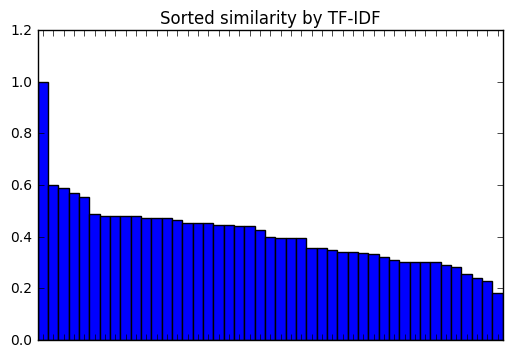

Top 10:


[('03-Essay09 03-Essay10', 1.0000000000000033),
 ('03-Essay02 03-Essay04', 0.59806747856548104),
 ('03-Essay02 03-Essay06', 0.58743640090218663),
 ('03-Essay02 03-Essay08', 0.56926997799162171),
 ('03-Essay04 03-Essay06', 0.55371135593726029),
 ('03-Essay04 03-Essay08', 0.48620789590116298),
 ('03-Essay05 03-Essay09', 0.48126684213491722),
 ('03-Essay05 03-Essay10', 0.48126684213491705),
 ('03-Essay04 03-Essay05', 0.4793432449764688),
 ('03-Essay01 03-Essay02', 0.47892275227557179)]

In [88]:
import nltk, string
from sklearn.feature_extraction.text import TfidfVectorizer
from collections import Counter
import matplotlib.pyplot as plt
import operator

#nltk.download('punkt') # if necessary...

stemmer = nltk.stem.porter.PorterStemmer()
remove_punctuation_map = dict((ord(char), None) for char in string.punctuation)

def stem_tokens(tokens):
    return [stemmer.stem(item) for item in tokens]

'''remove punctuation, lowercase, stem'''
def normalize(text):
    return stem_tokens(nltk.word_tokenize(text.lower().translate(remove_punctuation_map)))

vectorizer = TfidfVectorizer(tokenizer=normalize, stop_words='english')

def cosine_sim(text1, text2):
    tfidf = vectorizer.fit_transform([text1, text2])
    return ((tfidf * tfidf.T).A)[0,1]

similatity = dict()
for i in range(len(sources)):
    for j in range(i+1,len(sources)):
        similatity[files[i] + " " + files[j]] = cosine_sim(sources[i], sources[j])
        #print(files[i], files[j], cosine_sim(sources[i], sources[j]))

cnt = Counter(similatity)

sorted_cnt = sorted(cnt.items(), key=operator.itemgetter(1), reverse=True)
#print(sorted_cnt)

labels, values = zip(*sorted_cnt)

indexes = np.arange(len(labels))
width = 1

plt.bar(indexes, values, width)
plt.xticks(indexes + width * 0.5, [])
plt.title('Sorted similarity by TF-IDF')
plt.show()

print("Top 10:")
cnt.most_common(10)